In [17]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from util import *

# set path to data folder
root = "F:/Studium/Master/semester5/thesis/data/dataset/"

# definition of the true positive species zymoMock
species_zymo_mock = {
    "Pseudomonas aeruginosa",
    "Escherichia coli",
    "Salmonella enterica",
    "Staphylococcus aureus",
    "Limosilactobacillus fermentum",
    "Enterococcus faecalis",
    "Listeria monocytogenes",
    "Bacillus subtilis",
    "Saccharomyces cerevisiae",
    "Cryptococcus neoformans"}

# definition of the true positive species zymoOral
species_zymo_oral = {
    "Streptococcus parasanguinis",
    "Veillonella parvula",
    "Neisseria subflava",
    "Prevotella nigrescens",
    "Streptococcus mitis",
    "Haemophilus parainfluenzae",
    "Schaalia odontolytica",
    "Rothia dentocariosa",
    "Streptococcus salivarius",
    "Fusobacterium nucleatum",
    "Streptococcus mutans",
    "Porphyromonas gingivalis"}

# total read count in zymoMock dataset
total_zymo_mock = 1_160_526
# total read count in zymoOral dataset
total_zymo_oral = 1_140_052
# reading the taxonomic tree
tree = Tree(root + "tree_nr.txt")
# generate dictionary with all taxa that are true positives for each taxonomic rank
true_taxons_zymo_mock = get_true_taxons_for_all_ranks(tree, species_zymo_mock)
true_taxons_zymo_oral = get_true_taxons_for_all_ranks(tree, species_zymo_oral)

In [6]:
# read table with paths to datasets and metadata
data_zymo_mock_metadata = pd.read_csv("datasets_zymo_mock_metadata.tsv", sep="\t", header=0).fillna("")
data_zymo_mock = pd.DataFrame()
for i, row in data_zymo_mock_metadata.iterrows():
    # filter out other k-mer sizes
    if row["database"] not in ["NR", "NR Kraken 2X"]:
        continue
    # read per taxon assignment files and keep taxa with at least one read assigned by the "OVO (1.00) read count cumulative" algorithm
    per_taxon_assignment = read_per_taxon_assignment(root + row.path, kmer_threshold=0, ovo_1_threshold=1)
    # classify taxa as true positive or false positive
    per_taxon_assignment = classify_assigned_taxa(per_taxon_assignment, true_taxons_zymo_mock)
    # calculate precision and recall
    per_taxon_assignment = get_precision_recall_for_algorithm(per_taxon_assignment, "OVO (1.00) kmer count (cumulative)", total_zymo_mock)
    per_taxon_assignment["database"] = row["database"]
    data_zymo_mock = pd.concat([data_zymo_mock, per_taxon_assignment], ignore_index=True, axis=0)
data_zymo_mock

true positive,rank,false positive,true positive,precision,recall,database
0,class,56403.0,1047614.0,0.948911,0.902706,NR Kraken 2X
1,family,60992.0,1026844.0,0.943933,0.884809,NR Kraken 2X
2,genus,78801.0,949631.0,0.923378,0.818276,NR Kraken 2X
3,kingdom,15189.0,952270.0,0.984300,0.820550,NR Kraken 2X
4,order,58212.0,1036442.0,0.946822,0.893080,NR Kraken 2X
5,phylum,37889.0,1075198.0,0.965960,0.926475,NR Kraken 2X
6,species,132581.0,745913.0,0.849081,0.642737,NR Kraken 2X
7,superkingdom,1068.0,1135020.0,0.999060,0.978022,NR Kraken 2X
8,class,36027.0,1045163.0,0.966678,0.900594,NR
9,family,31645.0,1029054.0,0.970166,0.886713,NR


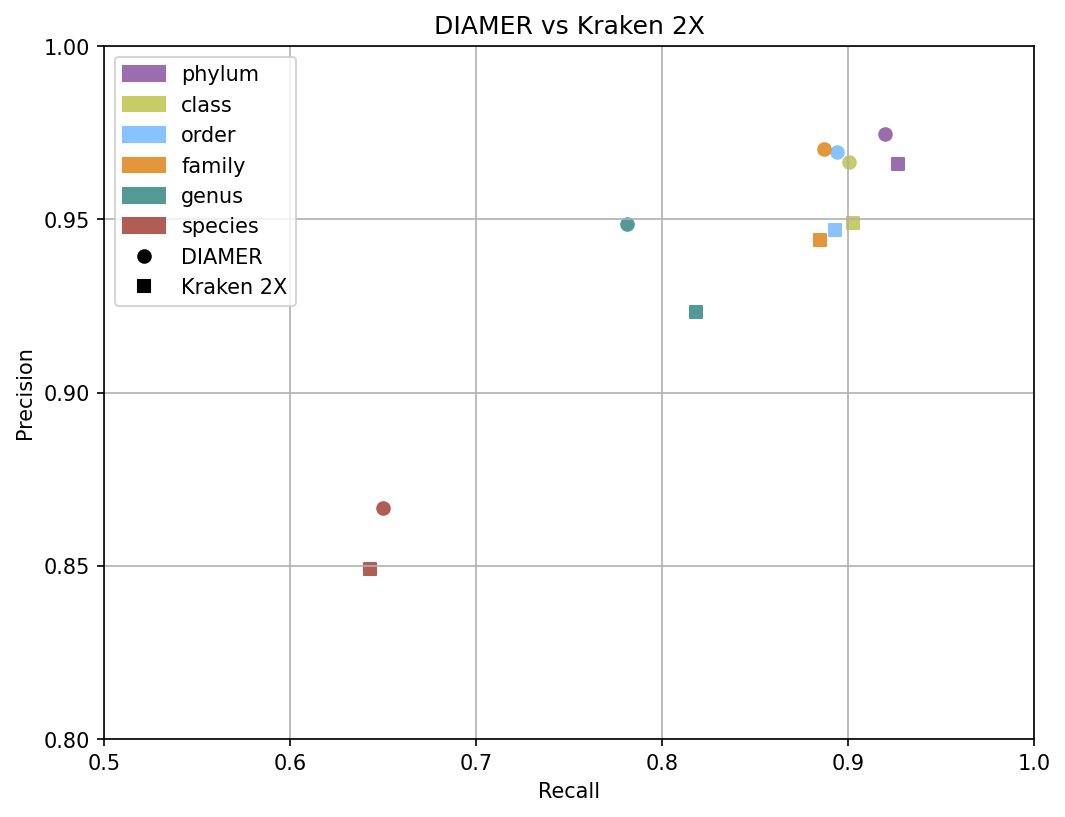

In [16]:
ranks = ["phylum", "class", "order", "family", "genus", "species"]
colors = ["#9a6dad", "#c7cc67", "#87c4ff", "#e4963a", "#539a97", "#af5d55"]
markers = ["o", "s"]

# creating legends
handles_colors = []
handles_symbols = [
    Line2D([], [], marker="o", color="black", label="DIAMER", linestyle="None"),
    Line2D([], [], marker="s", color="black", label="Kraken 2X", linestyle="None")
]

plt.figure(figsize=(8, 6), dpi=150)

for rank, color in zip(ranks, colors):
    handles_colors.append(Patch(color=color, label=rank))
    data_filtered_kraken = data_zymo_mock[(data_zymo_mock["rank"] == rank) & (data_zymo_mock["database"] == "NR Kraken 2X")]
    data_filtered_diamer = data_zymo_mock[(data_zymo_mock["rank"] == rank) & (data_zymo_mock["database"] == "NR")]
    plt.scatter(data_filtered_kraken["recall"], data_filtered_kraken["precision"], label=rank, color=color, marker="s")
    plt.scatter(data_filtered_diamer["recall"], data_filtered_diamer["precision"], label=rank, color=color, marker="o")

plt.xlim(0.5, 1)
plt.ylim(0.8, 1)
plt.xticks(np.arange(0.5, 1.01, 0.1))
plt.yticks(np.arange(0.8, 1.01, 0.05))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("DIAMER vs Kraken 2X")
plt.grid()

plt.legend(handles=handles_colors + handles_symbols)
plt.show()

In [18]:
# read table with paths to datasets and metadata
data_zymo_oral_metadata = pd.read_csv("datasets_zymo_oral_metadata.tsv", sep="\t", header=0).fillna("")
data_zymo_oral = pd.DataFrame()
for i, row in data_zymo_oral_metadata.iterrows():
    # filter out other k-mer sizes
    if row["database"] not in ["NR", "NR Kraken 2X"]:
        continue
    # read per taxon assignment files and keep taxa with at least one read assigned by the "OVO (1.00) read count cumulative" algorithm
    per_taxon_assignment = read_per_taxon_assignment(root + row.path, kmer_threshold=0, ovo_1_threshold=1)
    # classify taxa as true positive or false positive
    per_taxon_assignment = classify_assigned_taxa(per_taxon_assignment, true_taxons_zymo_oral)
    # calculate precision and recall
    per_taxon_assignment = get_precision_recall_for_algorithm(per_taxon_assignment, "OVO (1.00) kmer count (cumulative)", total_zymo_oral)
    per_taxon_assignment["database"] = row["database"]
    data_zymo_oral = pd.concat([data_zymo_oral, per_taxon_assignment], ignore_index=True, axis=0)
data_zymo_oral

true positive,rank,false positive,true positive,precision,recall,database
0,class,2678.0,1136476.0,0.997649,0.996863,NR Kraken 2X
1,family,3811.0,1134365.0,0.996652,0.995012,NR Kraken 2X
2,genus,4976.0,1132097.0,0.995624,0.993022,NR Kraken 2X
3,kingdom,423.0,589907.0,0.999283,0.517439,NR Kraken 2X
4,order,3628.0,1134896.0,0.996813,0.995477,NR Kraken 2X
5,phylum,475.0,1139112.0,0.999583,0.999175,NR Kraken 2X
6,species,265539.0,812985.0,0.753794,0.713112,NR Kraken 2X
7,superkingdom,459.0,1139424.0,0.999597,0.999449,NR Kraken 2X
8,class,2247.0,1136371.0,0.998027,0.996771,NR
9,family,6032.0,1131224.0,0.994696,0.992256,NR


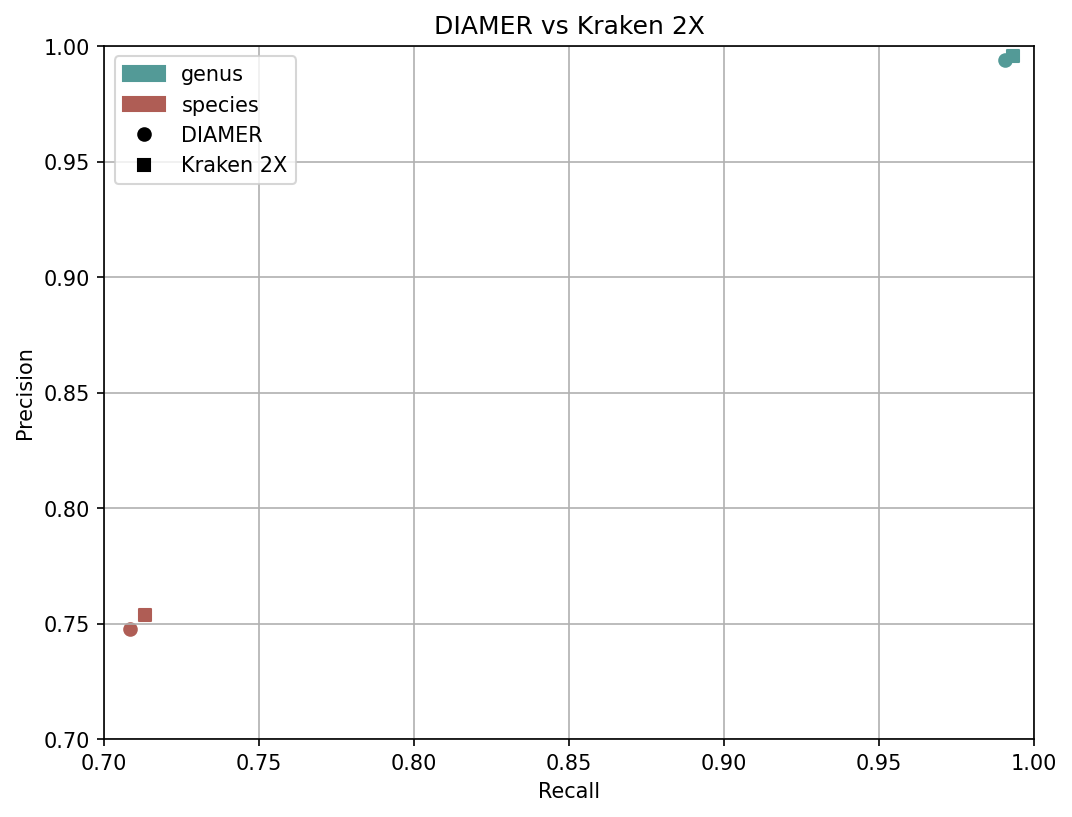

In [30]:
ranks = ["genus", "species"]
colors = ["#539a97", "#af5d55"]

# creating legends
handles_colors = []
handles_symbols = [
    Line2D([], [], marker="o", color="black", label="DIAMER", linestyle="None"),
    Line2D([], [], marker="s", color="black", label="Kraken 2X", linestyle="None")
]

plt.figure(figsize=(8, 6), dpi=150)

for rank, color in zip(ranks, colors):
    handles_colors.append(Patch(color=color, label=rank))
    data_filtered_kraken = data_zymo_oral[(data_zymo_oral["rank"] == rank) & (data_zymo_oral["database"] == "NR Kraken 2X")]
    data_filtered_diamer = data_zymo_oral[(data_zymo_oral["rank"] == rank) & (data_zymo_oral["database"] == "NR")]
    plt.scatter(data_filtered_kraken["recall"], data_filtered_kraken["precision"], label=rank, color=color, marker="s")
    plt.scatter(data_filtered_diamer["recall"], data_filtered_diamer["precision"], label=rank, color=color, marker="o")

plt.xlim(0.7, 1)
plt.ylim(0.7, 1)
plt.xticks(np.arange(0.7, 1.01, 0.05))
plt.yticks(np.arange(0.7, 1.01, 0.05))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("DIAMER vs Kraken 2X")
plt.grid()

plt.legend(handles=handles_colors + handles_symbols)
plt.show()